# ProxSkip

## Постановка задачи

Рассмотрим следующую задачу минимизации:
$$ \min_{x \in \mathbb{R}^d} (f(x) + \psi(x))\ \ \ \ \ \ \ \ (1)$$
где $f: \mathbb{R}^d \rightarrow \mathbb{R}$ - выпуклая функция, $\psi: \mathbb{R}^d \rightarrow \mathbb{R} \cup \{\infty\}$ - регуляризатор.

### Proximal Gradient Descent
Proximal Gradient Descent - подход к решению задачи $(1)$. Это итеративный алгоритм со следующим шагом:
$$ x_{t+1} = prox_{\gamma_t \psi}(x_t  - \gamma_t \nabla f(x_t)) $$
Где:
1. $x_t$ - приближение ответа в момент времени $t$.
2. $\gamma_t$ - шаг в момент времени $t$.
3. $prox_{\gamma \psi} := argmin_{y \in \mathbb{R}^d} \left( \frac12 \|y-x\|^2 + \gamma \psi(y) \right)$ - оператор приближения.

Как правило, вычисление градиента в Proximal Gradient Descent является более вычислительно сложным, чем вычисление оператора приближения. Однако в данной статье рассматривается ситуация, когда оператор приближения по сложности вычисления сравним с градиентом.

### Распределенные вычисления
Рассмотрим следующую задачу. Пусть есть $n$ кластеров/нод/вычислительных клиентов, и $i$-ый кластер вычисляет функцию $f_i: \mathbb{R}^d \rightarrow \mathbb{R}$. Рассмотрим задачу минимизации функции $f(x) := \frac1n \sum\limits_{i=1}^n f_i(x)$:
$$ \min_{x \in \mathbb{R}^d} f(x) $$
Эта задача актуальна для современного машинного обучения, т.к. является абстракцией над задачей минимизации эмпирического риска. \
Посмотрим на частный случай задачи $(1)$ в распределенном виде:
$$ \min_{x_1, \dots, x_n \in \mathbb{R}^d} \frac1n \sum\limits_{i=1}^{n} f_i(x_i) + \psi(x_1, \dots, x_n)$$
где $\psi(x_1, \dots, x_n) = 0$ при $x_1 = \dots = x_n$, $+\infty$ иначе. \
При такой задаче локальный подсчет функции $f_i$ на $i$-ом кластере - не очень сложная вычислительная задача, а главная трудность кроется в коммуникации между кластерами. \
Подобные задачи возникают в федеративном обучении. Разрабатываются алгоритмы для сокращения коммуникации и достижения хорошего временного соотношения для коммуникации и вычислений. Бегло посмотрим на вклад данной статьи в решении подобных задач.

### Идеи и обощения ProxSkip
ProxSkip - обобщение метода Proximal Gradient Descent для решения задачи $(1)$. Суть метода заключается в том, что вместо вычисления значения оператора $prox$ на каждом шаге, он вычисляется с некоторой вероятностью $p \in (0, 1]$. \
Для того, чтобы эффективность метода была доказуема, используется валидационное слагаемое $h_t$. \
В статье описывается Scaffnew - метод применения ProxSkip к задачам федеративного обучения. 

Так же рассматриваются следующие **расширения** этого метода:
1. Переход от детерминированного вычисления градиента к стохастическому.
2. Переход от вычислений с центральным сервером к децентрализованным вычислениям.

## Реализация в коде и эксперименты

In [2]:
import jax
import numpy as np
import jax.numpy as jnp
import scipy.stats as sps
import matplotlib.pyplot as plt
import copy

### ProxSkip
Начнем с реализации алгоритма ProxSkip в общем виде.

In [3]:
def ProxSkip(gamma, p, x0, h0, T, f, nabla_f, phi):
    '''
    gamma - stepsize
    p - probability of skipping the prox
    x0 - initial iterate
    h0 - initial control variate
    T - number of iterations
    f - smooth function
    nabla_f - grad of smooth function
    phi - proper, closed and convex reqularizer
    '''
    curr_x = x0
    curr_h = h0
    
    coin = sps.bernoulli(p)
    
    for t in range(T):
        hat_x = curr_x - gamma * (nabla_f(curr_x) - curr_h)
        
        calc_prox = coin.rvs(size=1)[0]
        
        if calc_prox:
            prox_func = lambda x : ((gamma * phi(x)) / p)
            curr_x = prox(prox_func, hat_x - (gamma * curr_h) / p)
        else:
            curr_x = hat_x
            
        curr_h += p * (curr_x - hat_x) / gamma
        
    return curr_x   

### Scaffnew
Перейдем к реализации Scaffnew - применения ProxSkip-а к задачам федеративного обучения. Здесь предполагается, что у нас есть несколько параллельно работающих кластеров, и функция $g$ принимает массив $x$ и возвращает массив, $i$-ая компонента которого - $g_i(x_i)$, причем компоненты вычисляются параллельно и независимо друг от друга.

В методе используется функция update_x, которая должна параллельно для $i=1\dots n$ делать следующее: если $calc\_prox[i] = 1$, то заменить $curr\_x[i]$ на $\frac1n \sum\limits_{i=1}^{n} \hat x [i]$, иначе заменить $curr\_x[i]$ на $\hat x [i]$. 


In [471]:
# сравнить с LocalGD
def Scaffnew(gamma, p, x0, h0, T, g):
    '''
    gamma - stepsize
    p - probability of skipping the prox
    x0 - initial iterate, an array with equal components
    h0 - initial control variate, an array with zero sum of elements
    T - number of iterations
    g - a function to be computed in parallel
    update_x - parralel calculation of curr_x
    '''
    # можно убрать xs, hs, ps
    xs = []
    hs = []
    ps = []
    gs = []
    
    curr_x = x0 # матрица
    curr_h = h0
    prox_calls = 0
    n = len(x0)
    
    coin = sps.bernoulli(p)
    
    xs.append(copy.copy(curr_x))
    hs.append(copy.copy(curr_h))
    ps.append(0)
    gs.append(g(curr_x))
    
    
    
    for t in range(T):
        if t > 0 and t % 5000 == 0:
            print(str(t) + ' iterations are done')
        calc_prox = coin.rvs(size=1) # coin of dim=1
        
        hat_x = curr_x - gamma * (g(curr_x) - curr_h)
                
        if calc_prox:
            prox_calls += 1
            # log the result only after communication
            gs.append(g(curr_x))
            
            curr_x = np.linspace(np.mean(hat_x, axis=0), np.mean(hat_x, axis=0), n)
            xs.append(copy.copy(curr_x))
            hs.append(copy.copy(curr_h))
            ps.append(prox_calls)
        else:
            curr_x = hat_x
        
        
        curr_h += p * (curr_x - hat_x) / gamma   
        
        
    return xs, hs, ps, gs

Опережая события, выпишем теорему о сходимости этого метода, чтобы подобрать аргументы метода для воспроизведения экспериментов.

**Следствие 4.7 (о сходимости Scaffnew, из Т.3.6.).** Пусть выполнено предположение 4.1 и $\gamma = \frac{1}{L},\ p = \frac1{\sqrt{\kappa}},\ g_{i,t}(x_{i,t}) = \nabla f_i(x_{i,t})$. Тогда итерационная сложность Scaffnew - $O(\kappa \log\frac{1}{\varepsilon})$, оракульная сложность - $O(\sqrt{\kappa}\log\frac1{\varepsilon})$ (здесь оракул - усреднение значений на кластерах).

Начнем с глупого случая. Рассмотрим $n$ функций: $f_i(x) = \frac{i}{2} x_i^2,\ i=1,\dots,n$. \
Константы сильной выпуклости и Липшецевости градиента для $i$-ой функции: $\mu_i=i,\ L_i=i$. \
Это означает, что все функции являются $\mu$-сильновыпуклыми и $L$-липшицевыми для  $\mu=1,\ L=n$. \
При таких значениях $\mu,\ L:\ \kappa = \frac{L}{\mu} = n$, т.е. надо брать $p=\frac1{\sqrt{n}}$. \
При таком подборе $f_i$ надо брать $g_{i,t}(x_{i,t}) = \nabla f_i(x_{i,t}) = i x_{i,t}$.

In [512]:
n = 1000
mu = 1
L = n
gamma = 1 / L
p = 1 / np.sqrt(n)

x0 = np.linspace(1, 1, n)
h0 = np.linspace(0, 0, n)

T = 30

In [513]:
def g(x):
    return x * np.linspace(1, n, n)   

In [514]:
T = 10000
xs, hs, ps, gs = Scaffnew(gamma, p, x0, h0, T, g)
xs_lgd, hs_lgd, ps_lgd, gs_lgd = Scaffnew(gamma, 1, x0, h0, T, g)

5000 iterations are done
5000 iterations are done


In [515]:
def calc_errors(xs, hs, gamma, p):
    x_err = [np.power(np.linalg.norm(x), 2) for x in xs]
    h_err = [np.power(np.linalg.norm(h), 2) for h in hs]
    k = (gamma * gamma) / (p * p)
    psi = x_err + k * np.array(h_err)
    return x_err, h_err, psi

In [516]:
x_err, h_err, psi = calc_errors(xs, hs, gamma, p)
x_err_lgd, h_err_lgd, psi_lgd = calc_errors(xs_lgd, hs_lgd, gamma, 1)

In [517]:
print(len(xs))
print(len(ps))


325
325


(0.0, 40.0)

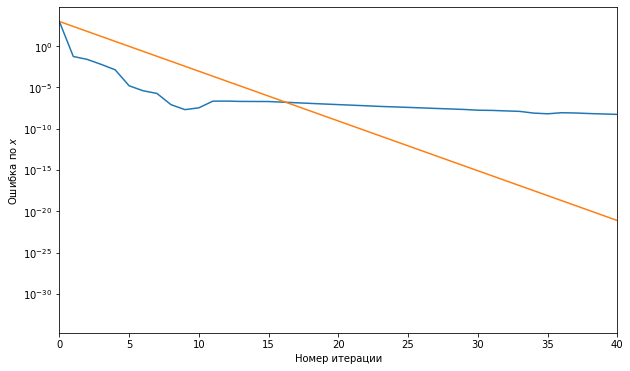

In [518]:
plt.figure(figsize=(10, 6))

plt.plot(ps, x_err, label='Scaffnew')
plt.plot(ps_lgd, x_err_lgd, label='Local GD')
plt.yscale('log')
plt.xlabel('Номер итерации')
plt.ylabel(r'Ошибка по $x$')
plt.xlim(0, 40)

Какая-то сходимость тут, конечно, просматривается, но не стоит забывать про то, что все это делается с использованием некоторой вероятности пропуска вызова оракула, поэтому запустим несколько эксперементов и посмотрим, как для них выглядит сходимость.

In [519]:
print(p)

0.03162277660168379


(0.0, 30.0)

<Figure size 720x864 with 0 Axes>

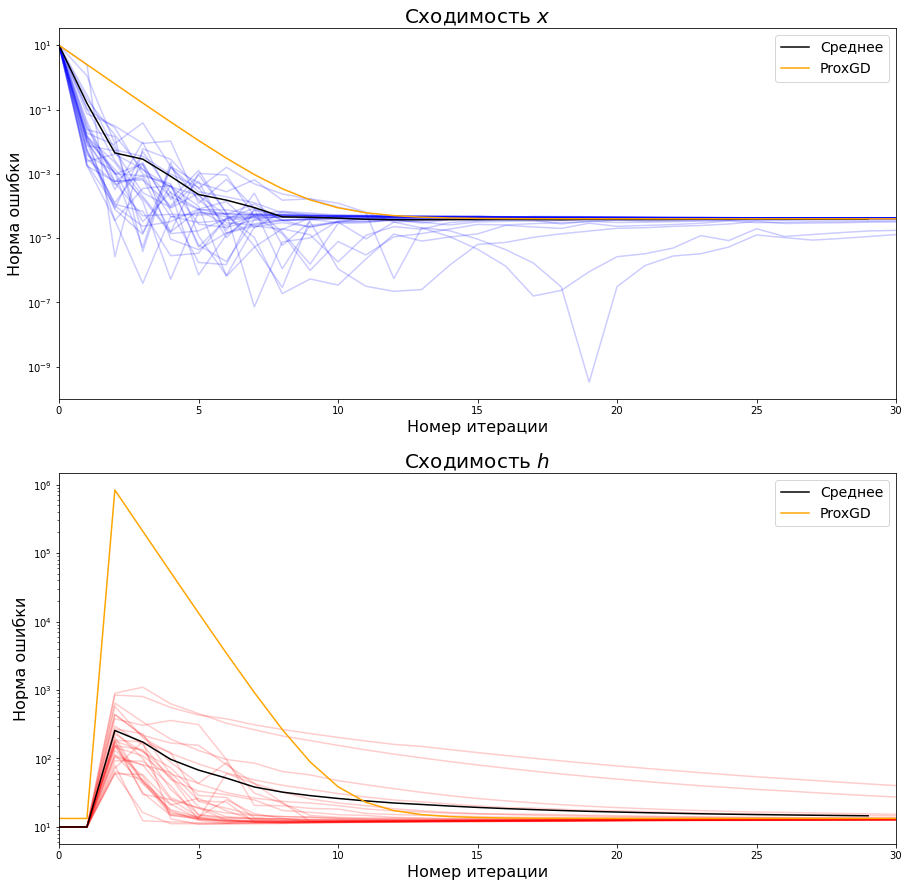

In [523]:
num_exp = 30
T = 3000

plt.figure(figsize=(10, 12))

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

its = 30

x_err_trend = np.linspace(0, 0, its)
h_err_trend = np.linspace(0, 0, its)


for i in range(num_exp):
    x0 = np.linspace(0.1, 0.1, n)
    h0 = np.linspace(0.1, 0.1, n)
    
    xs, hs, ps, gs = Scaffnew(gamma, p, x0, h0, T, g)
    
    x_err, h_err, psi = calc_errors(xs, hs, gamma, p)
    x_err_trend += x_err[:its]
    h_err_trend += h_err[:its]

    
    axs[0].plot(ps, x_err, alpha=0.2, color='blue')
    axs[1].plot(ps, h_err, alpha=0.2, color='red')
    
axs[0].plot(x_err_trend / num_exp, color='black', label='Среднее')
axs[1].plot(h_err_trend / num_exp, color='black', label='Среднее')
    

axs[0].set_title(r'Сходимость $x$', fontsize=20)
axs[1].set_title(r'Сходимость $h$', fontsize=20)

for i in range(2):
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Номер итерации', fontsize=16)
    axs[i].set_ylabel('Норма ошибки', fontsize=16)




xs_lgd, hs_lgd, ps_lgd, gs_lgd = Scaffnew(gamma, 1, x0, h0, T, g)
x_err_lgd, h_err_lgd, psi_lgd = calc_errors(xs_lgd, hs_lgd, gamma, 1)
axs[0].plot(ps_lgd, x_err_lgd, color='orange', label='ProxGD')
axs[1].plot(ps_lgd, h_err_lgd, color='orange', label='ProxGD')

axs[0].legend(fontsize=14)
axs[1].legend(fontsize=14)

axs[0].set_xlim(0, its)
axs[1].set_xlim(0, its)

Перейдем к более осмысленной задаче, а именно, к задаче логистической регрессии:
$$ f(x) = \frac1n \sum\limits_{i=1}^{n} \left(\log(1 + \exp(-b_i a_i^T x)) + \frac{\lambda}{2n} \| x \|^2 \right) $$
Здесь $b_i \in \{ -1, +1\}$, $a_i \in \mathbb{R}^d$ - элементы некоторой выборки данных. Будем использовать классический для нашего курса датасет mushrooms.txt.

Пусть кждый воркер занимается минимизацией логарифмической функции потерь на своем подмножестве исходного датасета размера $m$.

Фактически, мы взяли $f_i(x) =\sum\limits_{j=(i-1)m + 1}^{im} \log(1 + \exp(-b_j a_j^T x)) + \frac{m\lambda}{2n} \| x \|^2 $. \
Константы сильной выпуклости и Липшецевости градиента для $i$-ой функции: $\mu_i=\frac{m\lambda}{n},\ L_i=\frac1m \sum\limits_{j=(i-1)m + 1}^{im}\frac{\| a_i \|^2_2}{4}$. \
Это означает, что все функции являются $\mu$-сильновыпуклыми и $L$-липшицевыми для  $\mu=\frac{m\lambda}{n},\ L=\frac{A}{4n}$, где $A = \max\{\| a_i \|^2\}$ 

   В статье в качестве $\lambda$ советуют брать $10^{-4} L$. Тогда $\kappa = \frac{L}{\mu} = \frac{L}{\frac{Lm}{10^4 n}} = 10^4 n$, т.е. надо брать $p = \frac{\sqrt{m}}{100 \sqrt{n}}$. \
При таком подборе $f_i$ надо брать $g_{i,t}(x_{i,t}) = \nabla f_i(x_{i, t}) = \sum\limits_{j=(i-1)m + 1}^{im}  \frac{-b_j a_j}{1 + \exp(b_j x_{i,t}^T a_j)}$

Повторим шаги, проделанные ранее с другими функциями $f_i$, но предварительно выкачаем и подготовим датасет.

In [524]:
dataset = "mushrooms.txt"

from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
a, b = data[0].toarray(), data[1]
N = len(b)  
d = len(a[0])

b = 2 * b - 3
print(d)
print(N)

112
8124


In [525]:
batch_size = 40
batch_num = 40

n = batch_size * batch_num
a = a[:n]
b = b[:n]
L = np.max(np.linalg.norm(a, axis=1)) / 4
gamma = 1 / L
p = 1 / (100 * np.sqrt(batch_num))
lambd = L / 1e4

x0 = np.zeros(shape=(batch_num, d))
h0 = np.zeros(shape=(batch_num, d))

T = 10

In [526]:
print(gamma)

0.8728715609439696


In [527]:
def calc_f(x):
    arr = [np.log(1 + np.exp(-b[i] * a[i].T * x)) for i in range(n)]
    return np.mean(np.array(arr)) + lambd * np.linalg.norm(x) / 2
    

In [528]:
def g(x, batch_size, batch_num):
    ret = []
    for i in range(batch_num):
        # batchs == workers
        # calculate gradient separately for each worker
        curr_grad = 0
        for j in range(i * batch_size, (i + 1) * batch_size):
            denom = 1 + np.exp(b[j] * (x[i].T @ a[j]))
            curr_grad += -b[j] * a[j] / denom
            
        ret.append(curr_grad / batch_size)
        
    return np.array(ret)
   
def get_g(batch_size, batch_num):
    return lambda x: g(x, batch_size, batch_num)

**WARNING!** Эта клетка долгая!

In [529]:
L = np.max(np.linalg.norm(a, axis=1)) / 4
gamma = 1 / L
p = 1 / (100 * np.sqrt(batch_num))

x0 = np.ones(shape=(batch_num, d))  / 10
h0 = np.zeros(shape=(batch_num, d))

T = 2000

xs, hs, ps, gs = Scaffnew(gamma, 10 * p, x0, h0, T, get_g(batch_size, batch_num))
xs_lgd, hs_lgd, ps_lgd, gs_lgd = Scaffnew(gamma, 1, x0, h0, len(ps), get_g(batch_size, batch_num))

In [530]:
print(10 * p)
print(len(xs))

0.015811388300841896
28


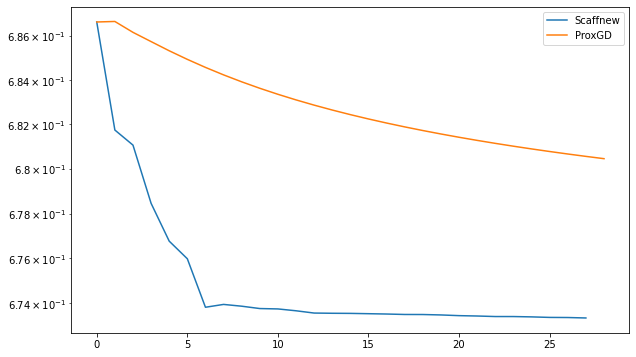

In [533]:
plt.figure(figsize=(10, 6))

iters = 30

fs = [calc_f(x) for x in xs[:iters]]
fs_lgd = [calc_f(x) for x in xs_lgd[:iters]]

plt.plot(fs, label='Scaffnew')
plt.plot(fs_lgd, label='ProxGD')
plt.legend()
plt.yscale('log')

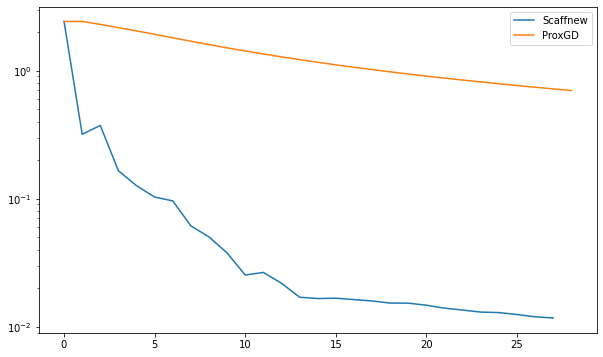

In [534]:
plt.figure(figsize=(10, 6))

iters = 30

g_norms = [np.linalg.norm(g) for g in gs[:iters]]
g_norms_lgd = [np.linalg.norm(g) for g in gs_lgd[:iters]]

plt.plot(g_norms, label='Scaffnew')
plt.plot(g_norms_lgd, label='ProxGD')
plt.legend()
plt.yscale('log')

Сравним на одном графике разные значения $p$ - вероятности пропуска подсчета проксимального оператора.

In [472]:
p_range = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
f_arr = []
g_arr = []

for p in p_range:
    print('Working on ' + str(p))
    T = int(40 / p)
    print('Gotta make ' + str(T) + ' iterations')
    xs, hs, ps, gs = Scaffnew(gamma, p, x0, h0, T, get_g(batch_size, batch_num))
    f_arr.append([calc_f(x) for x in xs])
    g_arr.append([np.linalg.norm(g) for g in gs])

Working on 0.001
Gotta make 40000 iterations
5000 iterations are done
10000 iterations are done
15000 iterations are done
20000 iterations are done
25000 iterations are done
30000 iterations are done
35000 iterations are done
Working on 0.005
Gotta make 8000 iterations
5000 iterations are done
Working on 0.01
Gotta make 4000 iterations
Working on 0.05
Gotta make 800 iterations
Working on 0.1
Gotta make 400 iterations
Working on 0.5
Gotta make 80 iterations
Working on 1
Gotta make 40 iterations


In [473]:
l = np.min(np.array([len(arr) for arr in f_arr]))
l

37

In [537]:
f_min = 10

for seq in f_arr:
    f_min = min(f_min, np.min(seq))
    
f_min

eps = 10e-4

0.6729286015790725

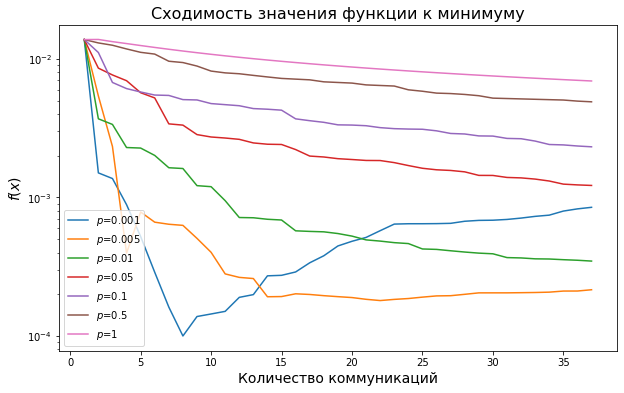

In [541]:
plt.figure(figsize=(10, 6))
iters = np.linspace(1, l, l)

for i in range(len(p_range)):
    plt.plot(iters, np.array(f_arr[i][:l]) - f_min + 10e-5, label='$p$='+str(p_range[i]))
    
plt.legend()
plt.xlabel('Количество коммуникаций', fontsize=14)
plt.ylabel(r'$f(x)$', fontsize=14)
plt.title('Сходимость значения функции к минимуму', fontsize=16)
plt.yscale('log')

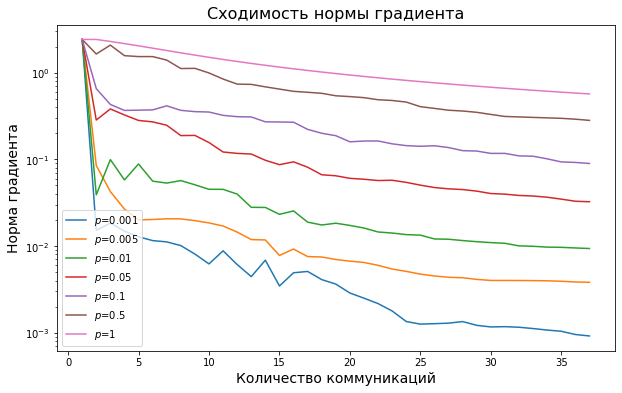

In [542]:
plt.figure(figsize=(10, 6))
iters = np.linspace(1, l, l)

for i in range(len(p_range)):
    plt.plot(iters, g_arr[i][:l], label='$p$='+str(p_range[i]))
    
plt.legend()
plt.xlabel('Количество коммуникаций', fontsize=14)
plt.ylabel('Норма градиента', fontsize=14)
plt.title('Сходимость нормы градиента', fontsize=16)
plt.yscale('log')

Перейдем к реализации Decentralized Scaffnew - обобщения Scaffnew, где вместо обычного среднего вычисляется взвешенное среднее.

In [5]:
def DecentralizedScaffnew(gamma, tau, p, x0, h0, W, T, f, nabla_f):
    '''
    gamma, tau - stepsizes
    p - probability of scipping the prox
    x0 - initial iterate, an array with equal components
    h0 - initial control variate, an array with zero elements
    W - weights for averaging
    f - smooth function
    grad_f - gradient of f
    '''
    curr_x = x0
    curr_h = h0
    n = len(x0)
    
    coin = sps.bernoulli(p)
    
    for t in range(T):
        hat_x = curr_x - gamma * (nabla_f(curr_x) - curr_h)
        
        calc_prox = coin.rvs(size=n)
        
        for i in range(n):
            if calc_prox[i]:
                k = (gamma * tau) / p
                curr_x[i] = (1 - k) * hat_x[i] + k * np.dot(W[i], x.T)
                curr_h[i] += p * (curr_x[i] - hat_x[i]) / gamma
            else:
                curr_x[i] = hat_x[i]
                # curr_h[i] = curr_h[i] - remains the same
            
        return curr_x

## Теоретическая часть
**Предположение 3.1.** Пусть $f$ - $L$-гладкая и $\mu$-сильно выпуклая функция. \
**Предположение 3.2.** Пусть $\psi$ - замкнутая, выпуклая, проксимально дружественная функция. \
В таких предположениях задача $(1)$ имеет единственное решение.

### Вспомогательные леммы
Рассмотрим леммы, которые используются в статье для доказательства основной теоремы.

**Лемма 3.3 (firm nonexpansiveness).** Пусть выполнено предположение 3.2. Пусть $P(x) := \text{prox}_{\frac{\gamma}{p} \psi}(x),\ Q(x) := x - P(x)$. Тогда 
$$ \| P(x) - P(y) \|^2 + \| Q(x) - Q(y) \|^2 \le \| x - y \|^2 \ \ \ \ \ \ \ (10) $$
для всех $x, y \in \mathbb{R}^d$ и любых $\gamma,\ p > 0$. \
**Доказательство:** \
Перепишем неравенство $(10)$ в эквивалентном виде:
$$ \| P(x) - P(y) \|^2 + \| x - y \|^2 + \| P(x) - P(y) \|^2 - 
2 \langle x - y, P(x) - P(y) \rangle \le \| x - y \|^2 $$
что равносильно:
$$ \langle x - y, P(x) - P(y) \rangle \ge \| P(x) - P(y) \|^2 $$
Это неравенство было доказано на лекции 11. 

Положим $x_*$ - решение задачи $(1)$, $h_* := \nabla f(x_*)$ (нашей целью будет показать, что $h_t$ действительно сходятся к $\nabla f(x_*)$. Для этого рассмотрим функцию Ляпунова:
$$ \Psi_t := \| x_t - x_* \|^2 + \frac{\gamma^2}{p^2} \| h_t - h_* \|^2 $$
Для удобства так же определим $w_t := x_t - \gamma \nabla f(x_t),\ w_* := x_* - \gamma \nabla f(x_*)$

**Лемма 3.4.** В предположениях 3.1 и 3.2, $\gamma > 0,\ 0 < p \le 1$ верно: 
$$ \mathbb{E}[\Psi_{t+1}] \le \| w_t - w_* \|^2 + (1 - p^2) \frac{\gamma^2}{p^2} \| h_t - h_* \|^2, $$
где математическое ожидание берется по $\theta_t$ - случайной величине, говорящей, считается ли на шаге $t$ значение проксимального оператора. $\theta_t \sim Bern(p)$ - распределение Бернулли с параметром $p$.

**Лемма 3.5.** Пусть предположение 3.1 выполнено при некотором $\mu > 0$. Возьмем $0 < \gamma \le \frac1L$. Тогда:
$$ \| w_t - w_* \|^2 \le (1 - \gamma \mu) \| x_t - x_* \|^2 $$

### О сходимости ProxSkip
**Теорема 3.6.** Пусть выполнены предположения 3.1 и 3.2, и $0 \gamma \le \frac1L,\ 0 < p \le 1.$ Тогда 
$$ \mathbb{E}[\Psi_T] \le (1 - \zeta)^T \Psi_0,\ \ \ \ \ \ \ (15) $$
где $\zeta := \min \{ \gamma \mu, p^2 \}$.

**Доказательство:** \
Комбинируя леммы 3.4 и 3.5, получаем:
$$ \mathbb{E}[\Psi_{t+1}] \le 
 \| w_t - w_* \|^2 + (1 - p^2) \frac{\gamma^2}{p^2} \| h_t - h_* \|^2 \le \newline \le
  (1 - \gamma \mu) \| x_t - x_* \|^2  + (1 - p^2) \frac{\gamma^2}{p^2} \| h_t - h_* \|^2 \le \newline \le
  (1 - \zeta) ( \| x_t - x_* \|^2 + \frac{\gamma^2}{p^2} \| h_t - h_* \|^2 ) = (1 - \zeta) \Psi_t$$
Тогда по индукции несложно доказать, что $ \mathbb{E}[\Psi_T] \le (1 - \zeta)^T \Psi_0 $.

**О подборе шага и $p$.** \
Во-первых, при $p=1$ ProxSkip эквивалентен ProxGD и имеет такую же сложность. \
Во-вторых, если мы зафиксируем размер шага $\gamma > 0$, то для всех $p \in [\sqrt{\gamma \mu}, 1]$ сложность будет одинаковой, т.к. сложность определяется значением $\zeta = \min\{\gamma \mu, p^2 \}$. Посмотрев на $(15)$, можно понять, что при $T \ge \frac{1}{\zeta}\log{\frac{1}{\varepsilon}}$ верно: $\mathbb{E}[\Psi_T] \le \varepsilon \Psi_0$. Т.е. ожидаемое количество вычислений проксимального оператора: \
$$ pT \sim \max\{\frac{p}{\gamma \mu}, \frac1p\} \log{\frac{1}{\varepsilon}}$$
Из замечания выше следует, что оптимальная вероятность $p = \sqrt{\mu \gamma}$,  и для максимально быстрой сходимости надо выбирать самый большой допустимый теоремой 3.6. шаг: $\gamma = \frac{1}{L}$. Выпишем, как надо подбирать параметры для ProxSkip, в отдельное следствие. Введем $\kappa = \frac{L}{\mu}$.

**Следствие 3.7.** При $\gamma = \frac1L,\ p = \frac{1}{\kappa}$ ожидаемая итерационная сложность алгоритма ProxSkip - $O(\kappa \log\frac{1}{\varepsilon})$, ожидаемая оракульная сложность - $O(\sqrt{\kappa} \log\frac1{\varepsilon})$ (оракул - подсчет проксимального оператора).

### Scaffnew
Теперь, как это ранее обещалось, применим ProxSkip для задачи федеративного обучения.

**Постановка задачи.** Требуется минимизировать среднее $n$ функций, подсчитываемых на $n$ устройствах:
$$ \min\limits_{x \in \mathbb{R}^d}\left\{ f(x) := \frac1n \sum\limits_{i=1}^n f_i(x) \right\}  $$

**Алгоритм Scaffnew.** \
**Шаг 1.** На каждом устройстве по отдельности обновить текущее значение локальной компоненты $x$: для $i \in [n]$ изменить $x_{i,t}$. \
**Шаг 2.** На каждом устройстве по отдельности обновить текущее значение локальной контрольной переменной $h$: для $i \in [n]$ изменить $h_{i,t}$. \
**Шаг 3.** С вероятностью $p$ для каждой итерации усреднить значения  $x$, полученные на клиентах.

**Предположение 4.1.** Пусть все $f_i$ - $L$-гладкие и $\mu$-сильновыпуклые.

**Следствие 4.7 (о сходимости Scaffnew, из Т.3.6.).** Пусть выполнено предположение 4.1 и $\gamma = \frac{1}{L},\ p = \frac1{\sqrt{\kappa}},\ g_{i,t}(x_{i,t}) = \nabla f_i(x_{i,t})$. Тогда итерационная сложность Scaffnew - $O(\kappa \log\frac{1}{\varepsilon})$, оракульная сложность - $O(\sqrt{\kappa}\log\frac1{\varepsilon})$ (здесь оракул - усреднение значений на кластерах).

### Стохастический градиент
Как мы знаем, часто подсчет полного градиента - это вычислительно сложная задача, поэтому на практике часто используется подсчет стохастического градиента. Для анализа мы будем использовать только несмещенные оценки градиента.

**Предположение 5.1 (несмещенность).** Для всех $t \ge 0$ верно:
$$ \mathbb{E}[g_t(x_t) | x_t] = \nabla f(x_t) $$
**Предположение 5.2 (ожидаемая гладкость).** Существуют константы $ A \ge 0$ и $C \ge 0$ такие что для всех $t \ge 0$ верно:
$$ \mathbb{E} [\|  g_t(x_t) - \nabla f(x_*) \|^2 | x_t] \le 2 A D_f(x_t, x_*) + C $$
**Предположение 5.3 (ограниченная вариация).** Для всех $t \ge 0$ верно:
$$ \mathbb{Var}[g_t(x_t) | x_t] \le \sigma^2 $$
**Лемма 5.4.** Пусть выполнены предположения 5.1 и 5.3, а также $f$ - выпуклая и $L$-гладкая функция, тогда предположение 5.2 верно при $A=L, C=\sigma^2$. 

**Теорема 5.5.** Пусть выполнены предположения 3.1, 3.2, 5.2 и 5.1. Пусть $0 < \gamma < \frac1A$ и $0 < p \le 1$. Тогда есть следующая оценка сходимости стохастического ProxSkip:
$$ \mathbb{E}[\Psi_t] \le (1 - \zeta)^T \Psi_0 + \frac{\gamma^2 C}{\zeta}$$
Внимательные слушатели курса методов оптимизации в МФТИ могут заметить, что так же как в случае с переходом от GD к стохастическому GD, при переходе от ProxSkip к стохастическому GD в оценке сходимости появилась добавка - в нашем случае - $\frac{\gamma^2 C}{\zeta}$.

**Следствие 5.6.** Рассмотрим алгоритм стохастического ProxSkip. Выберем любой $0 < \varepsilon < 1.$ Если мы возьмем $\gamma = \min\left\{ \frac1A, \frac{\varepsilon \mu}{2 C} \right\},\ p = \sqrt{\gamma \mu}$, то для того, чтобы гарантировать $\mathbb{E}[\Psi_t] \le \varepsilon$, достаточно выполнить $T \ge \max \left\{ \frac{A}{\mu}, \frac{2 C}{\varepsilon \mu^2}  \right\}\log\left( \frac{2 \Psi_0}{\varepsilon} \right)$ итераций, т.е. $  \max \left\{ \sqrt{\frac{A}{\mu}}, \sqrt{\frac{2 C}{\varepsilon \mu^2}}  \right\}\log\left( \frac{2 \Psi_0}{\varepsilon} \right)$ обращений к оракулу.

### Децентрализованное обучение
Пусть теперь взаимодействие - это не просто усреднение по всем нодам, а более сложный процесс. При каждом взаимодействии в ноде $i$ оказывается взвешенное среднее остальных нод с весами $W_{i1}, \dots, W_{in}$ соответственно. При этом ноды $i$ и $j$ обмениваются данными только если $W_{ij} \ne 0,\ W_{ji} \ne 0$. \
**Матрица весов.** $W$ - *mixing matrix*. Она должна быть симметричной, положительно полуопределенной, сумма чисел в каждой ее строке и каждом столбце должна быть равна 1. \
Тогда исходную задачу можно переформулировать так:
$$ \min\limits_{x \in \mathbb{R}^{dn}} f(x)\ s.t.\ (I - W)x = 0 $$ 
Здесь $I$ - единичная матрица подходящего размера. \
Обозначим в качестве $\textbf{L}$ квадратный корень из $I-W$ и определим индикаторную функцию $\psi$ следующим образом: $\psi(0) = 0,\ \forall y \ne 0\ \psi(y) = +\infty$. Ограничение $(I - W)x = 0$ эквивалентно ограничению $\textbf{L}x = 0$, а значит, нашу задачу можно переписать в виде:
$$ \min\limits_{x \in \mathbb{R}^{dn}} f(x) + \psi(\textbf{L}x) $$
**Определение.** Спектральным зазором матрицы $W$ назовем разность между двумя самыми большими собственными значениями матрицы $W$. Введем обозначение для спектрального зазора в нащем случае: $\delta := 1 - \lambda_2(W)$. \
**Теорема 5.7.** Пусть $f$ удовлетворяет предположению 4.1. Пусть $0 < p \le 1, \gamma < \frac1L, \tau \le \frac{p}{\gamma}$, тогда среднее по $x$ на итерации $T$ - $\overline{x_T}$ - удовлетворяет соотношению:
$$ \mathbb{E}[ \| \overline{x_T} - x_* \|^2 ] \le (1 - \min(\gamma \mu, p \gamma \tau \delta))^T \Phi_0,$$
где $\Phi_0 \le \| x_0 - x_* \|^2 + \frac{\gamma}{p \tau \delta n} \sum\limits_{i=1}^{n} \| \nabla f_i(x_*) \|^2 $. \
Если подставить $\tau = \frac{p}{\gamma}$, то получим оценку на итерационную сходимость $O(\kappa + \frac{1}{p^2 \delta})$.